In [70]:
from typing import List, Tuple
from functools import lru_cache

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import wandb

In [71]:
sns.set_style('whitegrid')
sns.set_palette('deep')

In [72]:
api = wandb.Api()

In [73]:
sns.set(font_scale=1.5)
sns.set_style('whitegrid')
sns.set_palette('deep')

In [99]:
def create_dataframe(keys, filters):
  runs = api.runs("gmum/nle", filters=filters)
  data = []
  for run in runs:
    try:
      df = run.history(samples=30000, keys=keys)
      df = pd.DataFrame(df)
      df["seed"] = run.config["seed"]
      data.append(df)
    except Exception as e:
      pass

  return pd.concat(data, axis=0).reset_index()

In [75]:
appo_filter = {
    "$or": [
        {"config.exp_tags": ["monk-APPO"], "config.exp_kind": "eval", "config.name": "eval_array"},
    ]
}
appo_t_filter = {
    "$or": [
        {"config.exp_tags": ["2023_11_05_monk-APPO-T"], "config.exp_kind": "eval", "config.name": "eval_array"},
        {"config.exp_tags": ["2023_11_05_monk-APPO-T"], "config.exp_kind": "eval_stitch"},
    ]
}
appo_kl_t_filter = {
    "$or": [
        {"config.exp_tags": ["2023_11_05_monk-APPO-AA-KL-T"], "config.exp_kind": "eval", "config.name": "eval_array"},
        {"config.exp_tags": ["2023_11_05_monk-APPO-AA-KL-T"], "config.exp_kind": "eval_stitch"},
    ]
}
appo_ks_t_filter = {
    "$or": [
        {"config.exp_tags": ["2023_11_05_monk-APPO-AA-KS-T"], "config.exp_kind": "eval", "config.name": "eval_array"},
        {"config.exp_tags": ["2023_11_05_monk-APPO-AA-KS-T"], "config.exp_kind": "eval_stitch"},
    ]
}

In [8]:
appo_df = create_dataframe(["eval/mean_episode_return", "global/env_train_steps"], appo_filter)

In [22]:
appo_t_df = create_dataframe(["eval/mean_episode_return", "global/env_train_steps"], appo_t_filter)

In [23]:
appo_kl_t_df = create_dataframe(["eval/mean_episode_return", "global/env_train_steps"], appo_kl_t_filter)

In [24]:
appo_ks_t_df = create_dataframe(["eval/mean_episode_return", "global/env_train_steps"], appo_ks_t_filter)

In [45]:
appo_df = appo_df.replace('NaN', pd.NA).dropna()
appo_t_df = appo_t_df.replace('NaN', pd.NA).dropna()
appo_kl_t_df = appo_kl_t_df.replace('NaN', pd.NA).dropna()
appo_ks_t_df = appo_ks_t_df.replace('NaN', pd.NA).dropna()

In [46]:
appo_df["index"] = (np.round(appo_df['global/env_train_steps'] / 100_000_000) * 100_000_000).astype(int)
appo_t_df["index"] = (np.round(appo_t_df['global/env_train_steps'] / 100_000_000) * 100_000_000).astype(int)
appo_kl_t_df["index"] = (np.round(appo_kl_t_df['global/env_train_steps'] / 100_000_000) * 100_000_000).astype(int)
appo_ks_t_df["index"] = (np.round(appo_ks_t_df['global/env_train_steps'] / 100_000_000) * 100_000_000).astype(int)

In [56]:
appo_t_df[appo_t_df["global/env_train_steps"] == 0]

,index,_step,eval/mean_episode_return,global/env_train_steps,seed
2,0,0.0,1906.787109,0.0,3
23,0,0.0,1943.928711,0.0,0
46,0,0.0,1768.871094,0.0,1
69,0,0.0,2008.850586,0.0,4
77,0,1024.0,1791.912109,0.0,0
91,0,1024.0,1964.72168,0.0,2
112,0,1024.0,1959.250977,0.0,1
130,0,1024.0,1856.904297,0.0,4
134,0,1024.0,2049.201172,0.0,3


In [65]:
appo_kl_t_df = appo_kl_t_df[np.logical_not(np.logical_and(appo_kl_t_df["index"] == 0, appo_kl_t_df["global/env_train_steps"] > 0))]

In [66]:
appo_ks_t_df = appo_ks_t_df[np.logical_not(np.logical_and(appo_ks_t_df["index"] == 0, appo_ks_t_df["global/env_train_steps"] > 0))]

In [68]:
appo_t_df = appo_t_df[np.logical_not(np.logical_and(appo_t_df["index"] == 0, appo_t_df["global/env_train_steps"] > 0))]

In [54]:
for seed in range(5):
    new_row = {'index': 0, 'eval/mean_episode_return': 0, "global/env_train_steps": 0, "seed": seed}
    appo_df = appo_df.append(new_row, ignore_index=True)

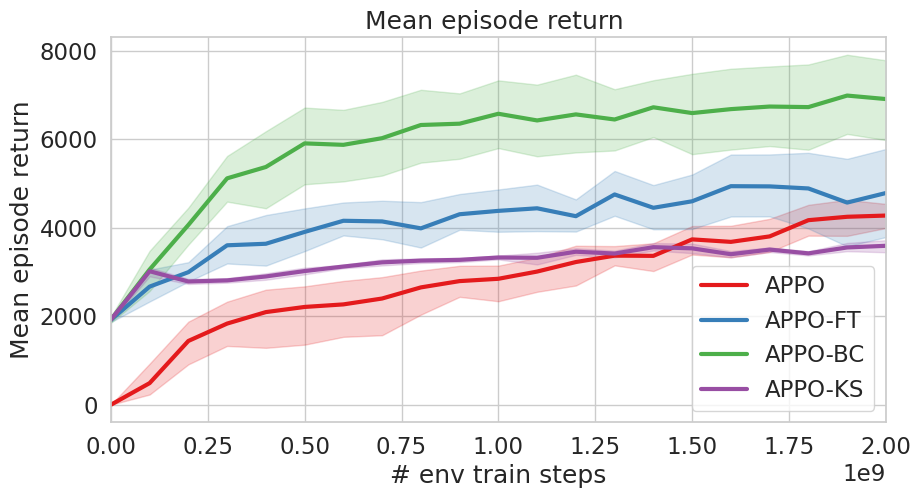

In [69]:
color_palette = sns.color_palette("Set1", 4)

fig, axes = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=appo_df, x="index", y="eval/mean_episode_return", ax=axes, errorbar=('ci', 90), linewidth=3, legend="full", label="APPO", color=color_palette[0])
sns.lineplot(data=appo_t_df.dropna(axis=0), x="index", y="eval/mean_episode_return", ax=axes, errorbar=('ci', 90), linewidth=3, legend="full", label="APPO-FT", color=color_palette[1])
sns.lineplot(data=appo_kl_t_df, x="index", y="eval/mean_episode_return", ax=axes, errorbar=('ci', 90), linewidth=3, legend="full", label="APPO-BC", color=color_palette[2])
sns.lineplot(data=appo_ks_t_df, x="index", y="eval/mean_episode_return", ax=axes, errorbar=('ci', 90), linewidth=3, legend="full", label="APPO-KS", color=color_palette[3])

# sns.lineplot(data=appo_t_for, x="index", y="eval/mean_forgetting_loss", ax=axes[1], errorbar=('ci', 90), linewidth=3, legend=False, label="APPO-FT", color=color_palette[1])
# sns.lineplot(data=appo_kl_t_for, x="index", y="eval/mean_forgetting_loss", ax=axes[1], errorbar=('ci', 90), linewidth=3, legend=False, label="APPO-BC", color=color_palette[2])
# sns.lineplot(data=appo_ks_t_for, x="index", y="eval/mean_forgetting_loss", ax=axes[1], errorbar=('ci', 90), linewidth=3, legend=False, label="APPO-KS", color=color_palette[3])

axes.set_xlabel("# env train steps")
axes.set_xlim(0, 2_000_000_000)

axes.set_title("Mean episode return ")
axes.set_ylabel("Mean episode return")

# axes[1].set_title("KL div on data generated by teacher")
# axes[1].set_ylabel("Kullback-Leibler Divergence")

plt.show(fig)

In [109]:
appo_t_for_filter = {
    "$or": [
        {"config.exp_tags": ["2023_11_05_monk-APPO-T"], "config.exp_kind": "eval", "config.name": "eval_forgetting"},
    ]
}
appo_kl_t_for_filter = {
    "$or": [
        {"config.exp_tags": ["2023_11_05_monk-APPO-AA-KL-T"], "config.exp_kind": "eval", "config.name": "eval_forgetting"},
    ]
}
appo_ks_t_for_filter = {
    "$or": [
        {"config.exp_tags": ["2023_11_05_monk-APPO-AA-KS-T"], "config.exp_kind": "eval", "config.name": "eval_forgetting"},
    ]
}

In [110]:
appo_t_for = create_dataframe(["global/env_train_steps", "eval/mean_forgetting_loss"], appo_t_for_filter)

In [111]:
appo_kl_t_for = create_dataframe(["global/env_train_steps", "eval/mean_forgetting_loss"], appo_kl_t_for_filter)

In [112]:
appo_ks_t_for = create_dataframe(["global/env_train_steps", "eval/mean_forgetting_loss"], appo_ks_t_for_filter)

In [113]:
appo_ks_t_for

,index,_step,global/env_train_steps,eval/mean_forgetting_loss,seed
0,0,1024,0.000000e+00,1.672900e-09,2
1,1,2049,1.000177e+08,5.912390e-02,2
2,2,3074,2.000328e+08,1.290020e-01,2
3,3,4099,3.000330e+08,1.232474e-01,2
4,4,5124,4.000512e+08,9.950075e-02,2
...,...,...,...,...,...
100,16,17424,1.600044e+09,6.529275e-02,3
101,17,18449,1.700010e+09,6.173574e-02,3
102,18,19474,1.800018e+09,7.055749e-02,3
103,19,20499,1.900045e+09,7.801683e-02,3


In [114]:
appo_t_for = appo_t_for.replace('NaN', pd.NA).dropna()
appo_kl_t_for = appo_kl_t_for.replace('NaN', pd.NA).dropna()
appo_ks_t_for = appo_ks_t_for.replace('NaN', pd.NA).dropna()

In [115]:
appo_t_for["index"] = (np.round(appo_t_for['global/env_train_steps'] / 100_000_000) * 100_000_000).astype(int)
appo_kl_t_for["index"] = (np.round(appo_kl_t_for['global/env_train_steps'] / 100_000_000) * 100_000_000).astype(int)
appo_ks_t_for["index"] = (np.round(appo_ks_t_for['global/env_train_steps'] / 100_000_000) * 100_000_000).astype(int)

In [116]:
appo_kl_t_for

,index,_step,global/env_train_steps,eval/mean_forgetting_loss,seed
0,0,1024,0.000000e+00,2.169191e-09,3
1,100000000,2049,1.000197e+08,6.010452e-02,3
2,200000000,3074,2.000210e+08,7.826310e-02,3
3,300000000,4099,3.000448e+08,7.932175e-02,3
4,400000000,5124,4.000481e+08,7.772146e-02,3
...,...,...,...,...,...
100,1600000000,17424,1.600041e+09,1.079606e-01,2
101,1700000000,18449,1.700008e+09,1.115983e-01,2
102,1800000000,19474,1.800046e+09,1.094215e-01,2
103,1900000000,20499,1.900051e+09,1.030671e-01,2


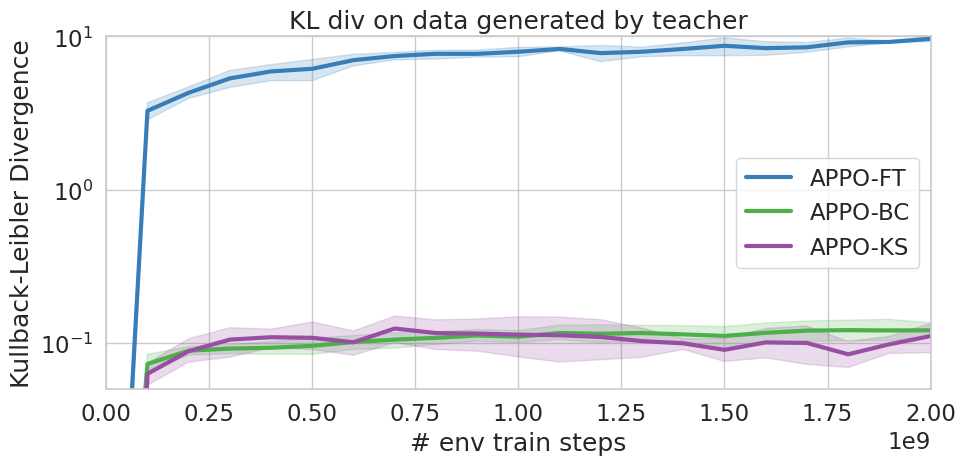

In [156]:
fig, axes = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=appo_t_for, x="index", y="eval/mean_forgetting_loss", ax=axes, errorbar=('ci', 90), linewidth=3, legend=True, label="APPO-FT", color=color_palette[1])
sns.lineplot(data=appo_kl_t_for, x="index", y="eval/mean_forgetting_loss", ax=axes, errorbar=('ci', 90), linewidth=3, legend=True, label="APPO-BC", color=color_palette[2])
sns.lineplot(data=appo_ks_t_for, x="index", y="eval/mean_forgetting_loss", ax=axes, errorbar=('ci', 90), linewidth=3, legend=True, label="APPO-KS", color=color_palette[3])

axes.set_xlabel("# env train steps")
axes.set_xlim(0, 2_000_000_000)

axes.set_title("KL div on data generated by teacher")
axes.set_ylabel("Kullback-Leibler Divergence")

axes.set_ylim(0.05, 10)
axes.set_yscale("log")

plt.show(fig)